# Real-world Data Science: Application of Visualization

In [2]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.decomposition import TruncatedSVD
from matplotlib.pyplot import figure
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

## Read the data

In [3]:
data = pd.read_csv("data/winemag-data_first150k.csv")

In [4]:
data.shape

(150930, 11)

The data contains 150930 rows and 11 columns.

In [5]:
list(data.columns)

['Unnamed: 0',
 'country',
 'description',
 'designation',
 'points',
 'price',
 'province',
 'region_1',
 'region_2',
 'variety',
 'winery']

It can be seen that one of them is an index and would not be needed for analysis so it can be dropped.

In [6]:
data = data[data.columns[1:]]

### Variables

**data** : used for EDA

**X** : features

**X_text** : text feature

**y** : response variable

**X_train**: training features

**y_train**: training response variable

**X_test**: test features

**y_test**: test response variable

In [7]:
X = data[["country", "designation", "price","province","region_1", "region_2","variety","winery"]]

In [8]:
X.head(3)

,country,designation,price,province,region_1,region_2,variety,winery
0,US,Martha's Vineyard,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,Carodorum Selección Especial Reserva,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Special Selected Late Harvest,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley


In [9]:
X_text = data[["description"]]

In [10]:
X_text.head(3)

,description
0,This tremendous 100% varietal wine hails from ...
1,"Ripe aromas of fig, blackberry and cassis are ..."
2,Mac Watson honors the memory of a wine once ma...


In [11]:
y = data[["points"]]

In [12]:
y.head(3)

,points
0,96
1,96
2,96


Replacing NA with the median of the data.

**This is strictly for EDA purposes**

In [13]:
data = data.fillna(data.median())

In [14]:
def boxplot_sorted(df, by, column,size):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values(ascending=False)[:10]
    df2[meds.index].boxplot(figsize=size)
    plt.xlabel("Country", fontsize=12)
    plt.ylabel("Points", fontsize=12)
    plt.title("Points distribution of top 10 countries")
    plt.xticks(rotation=90)
    plt.suptitle("")
    plt.show()
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values()[:10]
    df2[meds.index].boxplot(figsize=size)
    plt.xlabel("Country", fontsize=12)
    plt.ylabel("Points", fontsize=12)
    plt.title("Points distribution of bottom 10 countries")
    plt.xticks(rotation=90)
    plt.suptitle("")
    plt.show()

## Visualization 1 and 2

### Distribution of points for top and bottom 10 countries

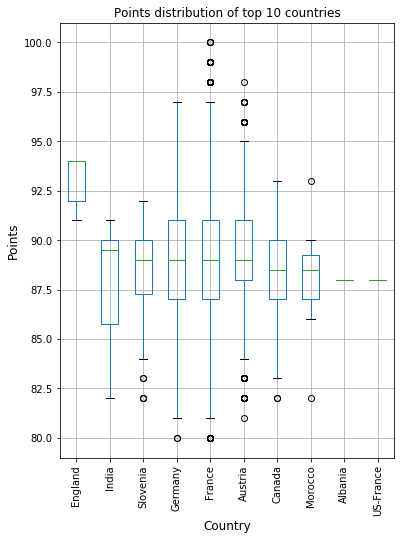

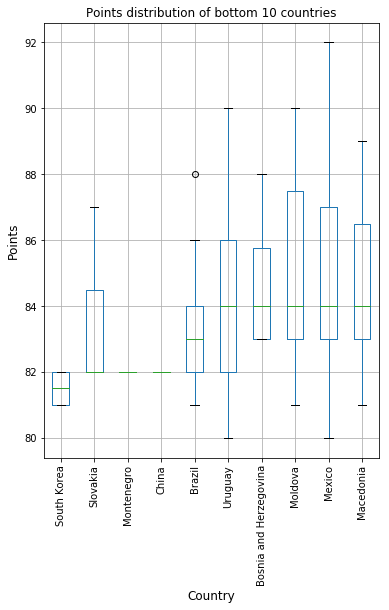

In [15]:
boxplot_sorted(data[["country", "points"]], "country", "points",(6,8))

A boxplot is an idiom which is typically used to graphically summarize a distribution. It uses 5 quantitative derived attributes to represent the distribution. The categorical attribute is on the horizontal axis and the quantitative attribute is on the vertical axis. It uses one glyph per original attribute to represent the derived attribute using vertial spatial position, with 1D list alignment of glyphs separated with horizontal spatial position. The information density using a boxplot is optimal leading to high scalability in terms of number of categorical attributes that can be plotted.

It can be seen from the visualization that there is a considerable difference between the distribution of points in the top 10 and the bottom 10 countries.

### Effect of price on points

In [16]:
data["priceLog"] = np.log(data["price"])

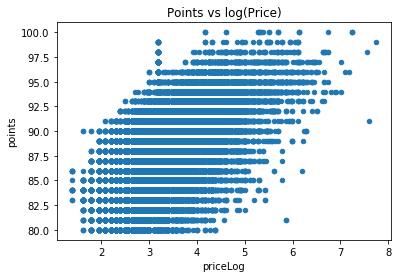

In [141]:
data[["priceLog", "points"]].plot.scatter(x="priceLog", y="points")
plt.title("Points vs log(Price)")
plt.show()

Scatterplot is an idiom used to encode two quantitative attributes using horizontal and vertical spatial position channels and a point mark.

It is possible to notice a decent correlation between log of the price and the points

## Preprocessing

Using the log of price since it has a better correlation with points.

In [18]:
X["priceLog"] = np.log(X["price"])

In [19]:
X_requiredFeatures = X[["country", "priceLog", "variety"]]

### One hot encoding

In [20]:
X_requiredFeatures_OHC = pd.get_dummies(X_requiredFeatures, sparse=True)

### Tf-Idf for text processing

In [21]:
vectorizer = TfidfVectorizer()
X_text_tfidf = vectorizer.fit_transform(list(X_text["description"]))

In [22]:
X_text_tfidf.shape

(150930, 30748)

The number of features is just too high. So I will be using dimensionality reduction in order to get features with highest variance. I will be using the LSA recommendation of 100 features.

**Truncated SVD**

In [23]:
svd = TruncatedSVD(n_components=100, n_iter=10, random_state=42)

In [24]:
svd_fit = svd.fit(X_text_tfidf)

In [25]:
svd_fit.explained_variance_ratio_.sum()

0.19087785686651934

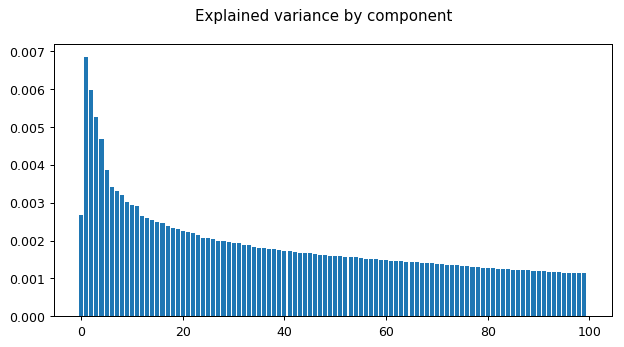

In [143]:
figure(num=None, figsize=(8, 4), dpi=90, facecolor='w', edgecolor='k')
plt.suptitle("Explained variance by component")
plt.bar(np.argsort(svd_fit.explained_variance_ratio_)[::-1], np.sort(svd_fit.explained_variance_ratio_)[::-1])
plt.show()

In [27]:
X_text_SVD = pd.DataFrame(svd.transform(X_text_tfidf))

In [28]:
X_requiredFeatures_OHC_text_SVD = pd.concat([X_requiredFeatures_OHC, X_text_SVD], axis=1)

## Split the data

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X_requiredFeatures_OHC_text_SVD, y, test_size=0.2, random_state=84)

In [30]:
trainingPriceMedian = X_train["priceLog"].median()

#### Fill NA with median of train data

In [32]:
X_train.loc[:,"priceLog"].fillna(trainingPriceMedian, inplace=True)
X_test.loc[:,"priceLog"].fillna(trainingPriceMedian, inplace=True)

### Scaling

In [33]:
scaler = StandardScaler().fit(X_train["priceLog"].values.reshape(-1,1))

In [35]:
X_train["priceLog"] = scaler.transform(X_train["priceLog"].values.reshape(-1,1))

In [37]:
X_test["priceLog"] = scaler.transform(X_test["priceLog"].values.reshape(-1,1))

## Modeling

### Define a baseline model

Here the baseline model is a simple linear regression.

### Linear Regression

In [38]:
lr = LinearRegression().fit(X_train, y_train)

In [89]:
def performance(model):
    return pd.DataFrame([[str(round(model.score(X_train, y_train),2)), str(round(-mean_squared_error(y_train, model.predict(X_train)),2))],[str(round(model.score(X_test, y_test), 2)), str(round(-mean_squared_error(y_test, model.predict(X_test)),2))]], index=["Training", "Test"], columns=["R-Squared", "Negative MSE"])

**Model performance**

In [90]:
performance(lr)

,R-Squared,Negative MSE
Training,0.63,-3.86
Test,-1.1446421017e+19,-1.18652981042e+20


The baseline performs well on the training set and not on the test set. There may be an overfitting problem with the baseline model due to the high dimensional nature of data.

One approach to prevent this would be to use a regularized linear models such as Ridge, Lasso and SVR.

Another approach to prevent overfitting would be to use ensemble learning algorithms such as RandomForest.

I would be using modeling the data using

- Ridge Regressor

- Linear SVR

- Random Forest Regressor

### Ridge CV

In [84]:
parameters = {
    "alpha" : [1e-3, 1e-2, 1e-1, 1]
}

In [85]:
ridgeGs = GridSearchCV(Ridge(), parameters, cv=10, scoring="neg_mean_squared_error")

In [87]:
ridgeGSFit = ridgeGs.fit(X_train, y_train)

In [93]:
ridgeBestModel = ridgeGSFit.best_estimator_.fit(X_train, y_train)

In [94]:
performance(ridgeBestModel)

,R-Squared,Negative MSE
Training,0.63,-3.86
Test,0.63,-3.85


This performs similar to Linear Regression on the training set and has a much better performance on the test set.

### Linear SVR

In [ ]:
kf = KFold(n_splits=10)
kf.get_n_splits(X_train)
svrCVnegMSE = []
svrCVR2 = []
for train_index, test_index in kf.split(X_train):
    X_train_tr, X_train_t = X_train.loc[X_train.index[train_index],:], X_train.loc[X_train.index[test_index],:]
    y_train_tr, y_train_t = y_train.loc[X_train.index[train_index],:], y_train.loc[X_train.index[test_index],:]
    svr = LinearSVR().fit(X_train_tr, y_train_tr)
    svrCVnegMSE.append(-mean_squared_error(y_train_t, svr.predict(X_train_t)))
    svrCVR2.append(svr.score(X_train_t, y_train_t))

**Average Test R-Squared**

In [95]:
sum(svrCVR2)/len(svrCVR2)

0.6220796665279085

**Average test negative MSE**

In [96]:
sum(svrCVnegMSE)/len(svrCVnegMSE)

-3.925351665452341

### Random Forest Regressor

In [98]:
parameters = {
    "max_depth" : [2, 4, 16 , 32],
    "n_estimators": [10, 20, 40]
}

In [99]:
rfRs = RandomizedSearchCV(RandomForestRegressor(max_features="sqrt", random_state=0, bootstrap=False), parameters, scoring="neg_mean_squared_error", cv=10)

In [101]:
rfGsFit = rfRs.fit(X_train, y_train)

In [117]:
rfBestModel = rfGsFit.best_estimator_.fit(X_train, y_train)

In [107]:
performance(rfBestModel)

,R-Squared,Negative MSE
Training,1.0,-0.01
Test,0.76,-2.51


## Visualization 3

In [114]:
bestScoreRf = [rfGsFit.cv_results_["split" + str(i) + "_test_score"][5] for i in range(1, 10)]
bestScoreRidge = [ridgeGSFit.cv_results_["split" + str(i) + "_test_score"][3] for i in range(1, 10)]

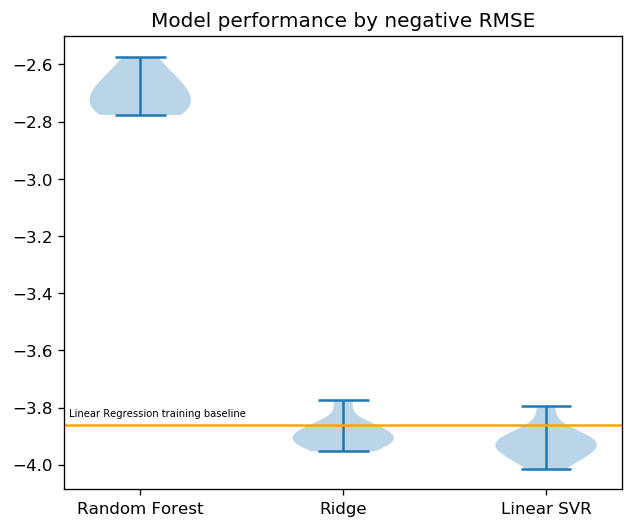

In [140]:
figure(figsize=(6,5), dpi=120)
plt.violinplot([bestScoreRf, bestScoreRidge, svrCVnegMSE])
plt.xticks([1, 2, 3], ("Random Forest", "Ridge", "Linear SVR"))
plt.axhline(y=-3.86, color="orange")
plt.text(0.65, -3.83, "Linear Regression training baseline", fontsize="6")
plt.title("Model performance by negative RMSE")
plt.show()

This plot shows the performance of the 3 models. Since the testing performance of Linear Regression was extremely poor, the training baseline is provided.

A violin plot uses the line and area mark. It uses spatial position channel for the horizontal axis while using a size and shape channel for the vertical axis. It is more informative than a standard boxplot which gives only summary statistics. This can be used to visualize the distribution of the data for the folds across each value of k.
The Linear regression training basline is encoded using line mark with vertical spatial position and color channel.

It can be seen that Random forest performs extremely well in comparison to the other models.

In [341]:
topFeatures = ["log(price)"] + ["SVD component " + str(r+1) for r in list(X_train.columns[[np.argsort(rfBestModel.feature_importances_)[::-1][:10]]]) if type(r) is not str]

## Visualization 4

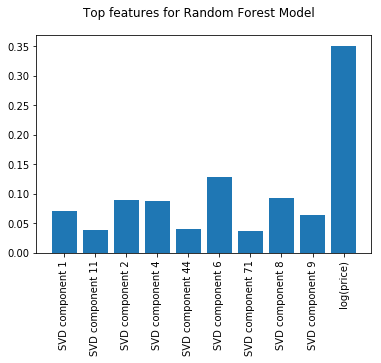

In [357]:
plt.xticks(rotation=90)
plt.suptitle("Top features for Random Forest Model")
plt.bar(topFeatures, np.sort(rfBestModel.feature_importances_)[::-1][:10]/sum(np.sort(rfBestModel.feature_importances_)[::-1][:10]))
plt.show()

A bar chart is used in order to display the top performing features. A bar chart is an ideal idiom for one categorical and one quantitative attribute.
A bar chart uses the line mark and vertical spatial position for the quantitative attribute and horizontal spatial position for the categorical attribute.

It can be seen that some of the components of the description and the price has a very impact on the points.